In [58]:
# sys
from abc import abstractmethod
import math
import requests
# torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
# image
from PIL import Image
import matplotlib.pyplot as plt
# process bar 
from tqdm import tqdm

%matplotlib inline

In [2]:
# util functions: time embedding 
# utils/utils.py

def time_embedding(time_step, dimension, max_period=1000):
    '''
    :param[in]  time_step   torch.Tensor [N], one per batch element.
    :param[in]  dimension   the dimension of output embedding.
    :param[in]  max_period  Sinusodial position embedding. 'Attention is all you need'

    :return     torch.Tensor    [N x dimension]
    '''
    half = dimension // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(device=time_step.device)
    args = time_step[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dimension % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [3]:
# util functions: extract
# utils/utils.py

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.to(t.device).gather(0, t).float()
    out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

In [4]:
# util base module and sequential
# utils/module.py

class Module(nn.Module):
    
    @abstractmethod
    def forward(self, x, t):
        raise NotImplemented
        
class Sequential(nn.Sequential, Module):
    
    @abstractmethod
    def forward(self, x, t):
        for layer in self:
            x = layer(x, t) if isinstance(layer, Module) else layer(x)
        return x

In [5]:
# unet components: sample block
# models/unet.py

class SampleBlock(Module):

    def __init__(
        self,
        sampling_type=None,
    ):
        super().__init__()

        # member variables
        if sampling_type == "up":
            self.sampling = nn.Upsample(scale_factor=2, mode="nearest")
        elif sampling_type == "down":
            self.sampling = nn.AvgPool2d(kernel_size=2, stride=2)
        else:
            self.sampling = nn.Identity()

    def forward(self, x, t=None):
        return self.sampling(x)

In [6]:
# unet components: residual block
# models/unet.py

class ResidualBlock(Module):

    def __init__(
        self,
        channel_in,
        channel_out,
        time_channel=None,
        dropout=0
    ):
        super().__init__()

        # member variables
        self.channel_base = channel_in
        self.channel_out = channel_out 

        # layer definition
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channel, self.channel_out)
        ) if time_channel is not None else None
        self.conv1 = nn.Sequential(
            nn.GroupNorm(32, self.channel_base),
            nn.SiLU(),
            nn.Conv2d(self.channel_base, self.channel_out, kernel_size=3, padding=1)
        )
        self.conv2 = nn.Sequential(
            nn.GroupNorm(32, self.channel_out),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(self.channel_out, self.channel_out, kernel_size=3, padding=1)
        )

        # skip connection
        if self.channel_base == self.channel_out:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(self.channel_base, self.channel_out, kernel_size=1)

    def forward(self, x, t=None):
        '''
        :param[in]  x   torch.Tensor [batch_size, x_channels, height, width]
        :param[in]  t   torch.Tensor [bathc_size, t_embedding]
        '''
        h = self.conv1(x)
        if t is not None and self.time_emb is not None:
            h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return self.skip_connection(x) + h

In [7]:
# unet
# models/unet.py

class UNet(Module):

    def __init__(
        self,
        channel_in,
        channel_out=None,
        channel_base=64,
        n_res_blocks=2,
        dropout=0,
        channel_mult={1, 2, 4, 8}
    ):

        super().__init__()

        # member variables
        self.channel_in = channel_in
        self.channel_out = channel_out or channel_in
        self.channel_base = channel_base
        self.n_res_blocks = n_res_blocks
        self.dropout = dropout

        # time embedding
        time_embedding_channel = channel_base * 4
        self.time_embedding = nn.Sequential(
            nn.Linear(self.channel_base, time_embedding_channel),
            nn.SiLU(),
            nn.Linear(time_embedding_channel, time_embedding_channel)
        )

        # input block 
        self.input = Sequential(
            nn.Conv2d(self.channel_in, self.channel_base, kernel_size=1)
        )
        channel_sequence = [channel_base]

        # temporary variables
        # ch: temporary input channel
        ch = self.channel_base 
        
        # encoder module list
        self.encoder_block = nn.ModuleList()
        for l, mult in enumerate(channel_mult):
            for _ in range(n_res_blocks):
                self.encoder_block.append(ResidualBlock(ch, mult * self.channel_base, time_channel=time_embedding_channel, dropout=dropout))
                ch = mult * self.channel_base
                channel_sequence.append(ch)
            if l != len(channel_mult) - 1:
                self.encoder_block.append(SampleBlock(sampling_type="down"))
                channel_sequence.append(ch)

        # bottomneck
        self.bottom_block = Sequential(
            ResidualBlock(ch, ch, time_channel=time_embedding_channel, dropout=dropout),
            ResidualBlock(ch, ch, time_channel=time_embedding_channel, dropout=dropout)
        )

        # decoder module list
        self.decoder_block = nn.ModuleList()
        for l, mult in reversed(list(enumerate(channel_mult))):
            for _ in range(n_res_blocks):
                self.decoder_block.append(ResidualBlock(ch + channel_sequence.pop(), mult * self.channel_base, time_channel=time_embedding_channel, dropout=dropout))
                ch = mult * self.channel_base
            if l > 0:
                self.decoder_block.append(
                    Sequential(
                        ResidualBlock(ch + channel_sequence.pop(), mult * self.channel_base, time_channel=time_embedding_channel, dropout=dropout),
                        SampleBlock(sampling_type="up")
                    )
                )
                ch = mult * self.channel_base

        # output block
        self.output = nn.Sequential(
            nn.GroupNorm(32, self.channel_base),
            nn.SiLU(),
            nn.Conv2d(ch, self.channel_out, kernel_size=1)
        )

    def forward(self, x, t=None):
        t_emb = self.time_embedding(time_embedding(t, self.channel_base)) if t is not None else None
        h = self.input(x, t)
        ht = [h]
        for module in self.encoder_block:
            h = module(h, t_emb)
            ht.append(h)
        h = self.bottom_block(h, t_emb)
        for module in self.decoder_block:
            h = torch.cat([h, ht.pop()], dim=1)
            h = module(h, t_emb)
        h = h.type(x.dtype)
        return self.output(h)

In [52]:
# gaussian diffusion
# models/diffusion.py

class GaussianDiffusion(nn.Module):
    
    def __init__(
        self,
        args,
    ):
        super().__init__()
        
        # member variables
        unet_args = args['unet']
        self.denoise_fn = UNet(**unet_args)
        self.time_steps = args['time_step']

        # parameters 
        scale = 1000 / self.time_steps
        betas = torch.linspace(scale * args['betas']['linear_start'], scale * args['betas']['linear_end'], self.time_steps, dtype=torch.float32)
        alphas = 1. - betas
        gammas = torch.cumprod(alphas, axis=0)
        gammas_prev = F.pad(gammas[:-1], (1, 0), value=1.)

        # diffusion q(x_t | x_{t-1}) 
        self.register_buffer('gammas', gammas)
        self.register_buffer('sqrt_reciprocal_gammas', torch.sqrt(1. / gammas))
        self.register_buffer('sqrt_reciprocal_gammas_m1', torch.sqrt(1. / gammas - 1))

        # posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1. - gammas_prev) / (1. - gammas)
        self.register_buffer('posterior_variance', posterior_variance)
        self.register_buffer('posterior_log_variance', torch.log(torch.clamp(posterior_variance, min=1e-20)))
        self.register_buffer('posterior_mean_coef1', betas * torch.sqrt(gammas_prev) / (1. - gammas))
        self.register_buffer('posterior_mean_coef2', (1. - gammas_prev) * torch.sqrt(alphas) / (1. - gammas))

        # loss function
        self.loss_fn = F.mse_loss

    def q_sample(self, x_0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_0)
        gammas_t = extract(self.gammas, t, x_shape=x_0.shape)
        return torch.sqrt(gammas_t) * x_0 + torch.sqrt(1 - gammas_t) * noise

    @torch.no_grad()
    def p_sample(self, x_t, t):
        predicted_noise = self.denoise_fn(x_t, t)
        predicted_x_0 = extract(self.sqrt_reciprocal_gammas, t, x_t.shape) * x_t - extract(self.sqrt_reciprocal_gammas_m1, t, x_t.shape) * predicted_noise
        predicted_x_0 = torch.clamp(predicted_x_0, min=-1., max=1.)
        posterior_mean = extract(self.posterior_mean_coef1, t, x_t.shape) * predicted_x_0 + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        posterior_log_variance = extract(self.posterior_log_variance, t, x_t.shape)
        noise = torch.randn_like(x_t)
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        pred_x = posterior_mean + nonzero_mask * (0.5 * posterior_log_variance).exp() * noise
        return pred_x
    
    @torch.no_grad()
    def inference(self, x_t):
        batch_size = x_t.shape[0]
        device = next(self.parameters()).device
        ret = []
        for i in tqdm(reversed(range(0, self.time_steps)), desc='Sampling time step', total=self.time_steps):
            x_t = self.p_sample(x_t=x_t, t=torch.full((batch_size, ), i, device=device, dtype=torch.long))
            ret.append(x_t.cpu().numpy())
        return ret

    def train(self, x, t):
        """
        :param[in]  x   torch.Tensor    [batch_size x channel x height x weight]
        :param[in]  t   torch.Tensor    [batch_size]
        """
        assert x.shape[0] == t.shape[0]
        # noise
        noise = torch.randn_like(x)
        # q sampling
        x_noisy = self.q_sample(x, t, noise=noise)
        # noise prediction
        noise_tilde = self.denoise_fn(x_noisy, t)
        return self.loss_fn(noise, noise_tilde)

In [53]:
# config 

config = {
    "time_step": 1000,
    "unet": {
        "channel_in": 1,
        "channel_mult": [1, 2, 2]
    },
    "betas": {
        "linear_start": 1e-6,
        "linear_end": 1e-2
    }
}

In [54]:
# dataset MNIST

batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

dataset = datasets.MNIST('/workspace/data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [55]:
# model object

device = "cuda" if torch.cuda.is_available() else "cpu"
gaussian_diffusion = GaussianDiffusion(config)
gaussian_diffusion.to(device)
optimizer = torch.optim.Adam(gaussian_diffusion.denoise_fn.parameters(), lr=5e-4)

In [56]:
print(next(gaussian_diffusion.parameters()).device)
print(next(gaussian_diffusion.denoise_fn.parameters()).device)

cuda:0
cuda:0


In [57]:
# train

epochs = 10

for epoch in range(epochs):
    print("Epoch: {0}".format(epoch))
    for step, (images, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        batch_size = images.shape[0]
        images = images.to(device)
        t = torch.randint(0, config['time_step'], (batch_size, ), device=device).long()
        loss = gaussian_diffusion.train(images, t)
        if step % 200 == 0:
            print("Loss: {0}".format(loss.item()))

        loss.backward()
        optimizer.step()

Epoch: 0
Loss: 0.9735535979270935
Loss: 0.05124370753765106
Loss: 0.054626960307359695
Loss: 0.05030682682991028
Loss: 0.04559331759810448
Epoch: 1
Loss: 0.04188279062509537
Loss: 0.03770066797733307
Loss: 0.03608831763267517
Loss: 0.04451035335659981
Loss: 0.033226415514945984
Epoch: 2
Loss: 0.03948601707816124
Loss: 0.029453067108988762
Loss: 0.03008810244500637
Loss: 0.04045548662543297
Loss: 0.033215608447790146
Epoch: 3
Loss: 0.043333180248737335
Loss: 0.03153874725103378
Loss: 0.022806094959378242
Loss: 0.034536659717559814
Loss: 0.041596509516239166
Epoch: 4
Loss: 0.03399008885025978
Loss: 0.03423723950982094
Loss: 0.03209349885582924
Loss: 0.03613397851586342
Loss: 0.035736892372369766
Epoch: 5
Loss: 0.03730307146906853
Loss: 0.03522187098860741
Loss: 0.03299009054899216
Loss: 0.03976501524448395
Loss: 0.03508567437529564
Epoch: 6
Loss: 0.03822227194905281
Loss: 0.03219343721866608
Loss: 0.027040556073188782
Loss: 0.030860837548971176
Loss: 0.033835269510746
Epoch: 7
Loss: 0.03

In [65]:
# ddpm inference with noise.

x_t = torch.randn((64, 1, 28, 28))
x_t = x_t.to(device)

generated_images = gaussian_diffusion.inference(x_t)

Sampling time step: 100%|██████████| 1000/1000 [00:08<00:00, 121.66it/s]


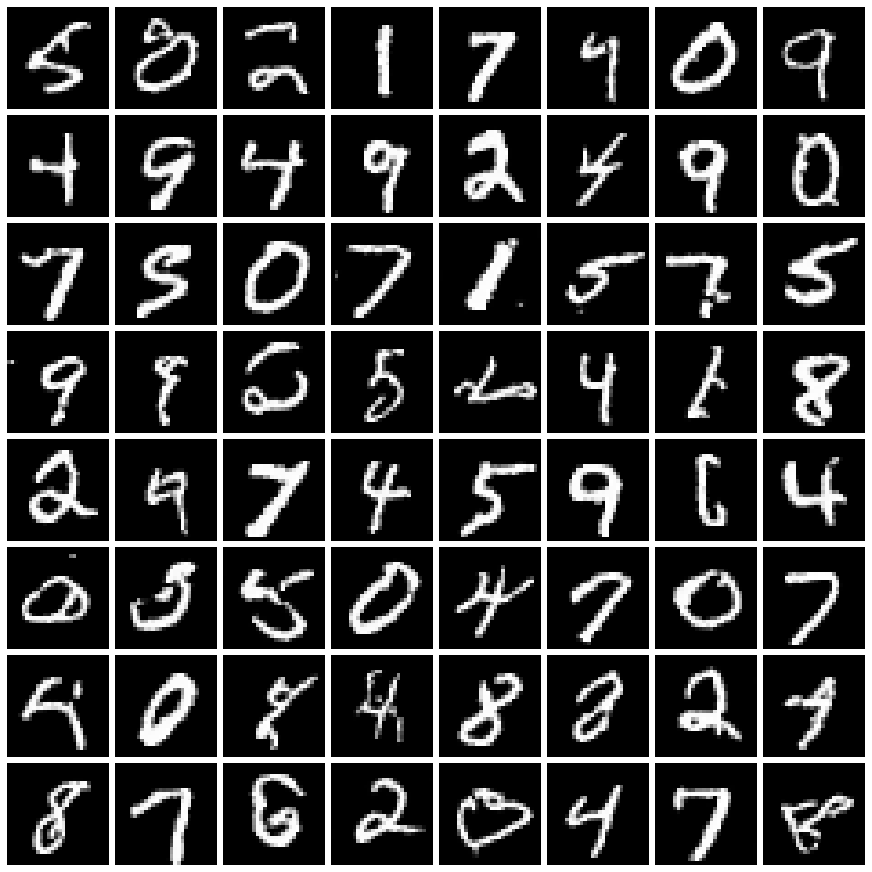

In [66]:
# show generated images.

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
grid_spec = fig.add_gridspec(8, 8)

rets = generated_images[-1].reshape(8, 8, 28, 28)
for r in range(8):
    for c in range(8):
        t_fig = fig.add_subplot(grid_spec[r, c])
        t_fig.imshow((rets[r, c]+1.0) * 255 / 2, cmap="gray")
        t_fig.axis("off")

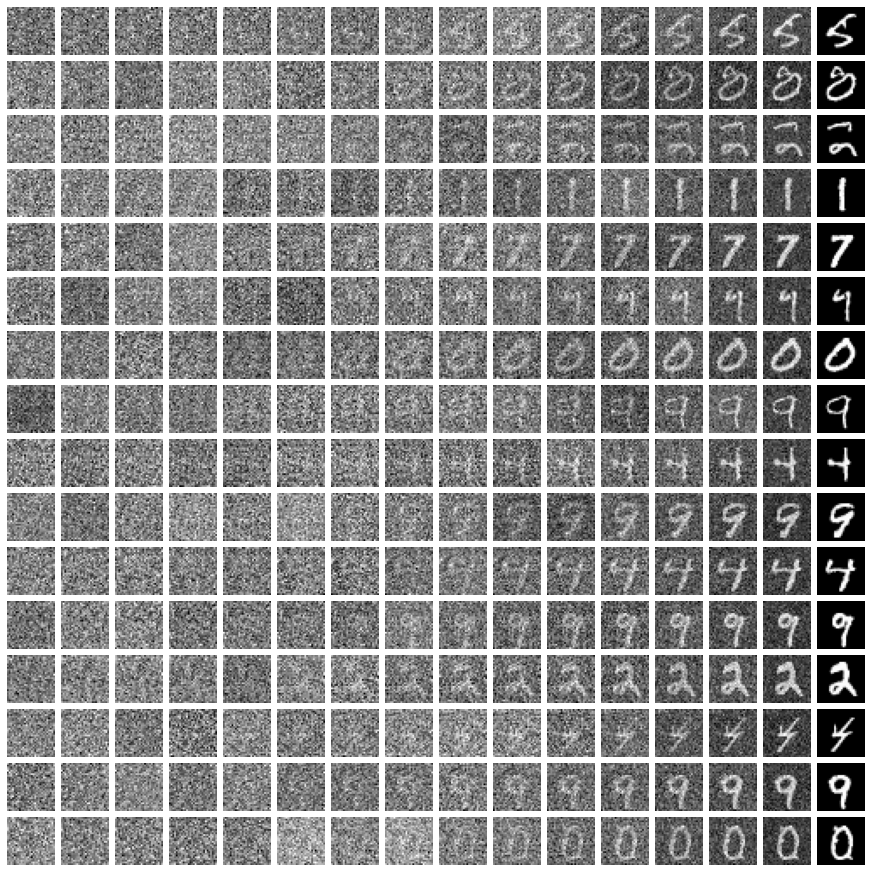

In [68]:
# show the denoise steps

fig = plt.figure(figsize=(12, 12), constrained_layout=True)
grid_spec = fig.add_gridspec(16, 16)

for r in range(16):
    for c in range(16):
        t_fig = fig.add_subplot(grid_spec[r, c])
        time_step = (config['time_step'] // 16) * c if c < 15 else -1
        img = generated_images[time_step][r].reshape(28, 28)
        t_fig.imshow((img+1.0) * 255 / 2, cmap="gray")
        t_fig.axis("off")